<a href="https://colab.research.google.com/github/jdanifalcon/match-rstudio-colab/blob/main/rbasicosig0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
#Instalación de librerías
install.packages("rgdal")
install.packages("rgeos")
install.packages("raster")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rgdal_1.5-23.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 4393536 bytes (4.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

In [29]:
%%R
library(rgdal)
library(rgeos)
library(raster)
#Descargo csv de temperaturas
system("gdown --id 1fAzgxOzSIoa2WAWlPOqQtV35SmICweS1")
#Archivo colima.shx
system("gdown --id 1OUzSMViEr30IGtUMVpbEGhNNkWOOOoll")#https://drive.google.com/file/d/1OUzSMViEr30IGtUMVpbEGhNNkWOOOoll/view?usp=sharing
#Archivo colima.shp
system("gdown --id 14lAl8FJ2USi-FP5TcKK9SpPJeDw8pN0u")#https://drive.google.com/file/d/14lAl8FJ2USi-FP5TcKK9SpPJeDw8pN0u/view?usp=sharing
#Archivo colima.dbf
system("gdown --id 1z4fzlcdKm_L64KCqQh3rqzN5ou35f1ny")#https://drive.google.com/file/d/1z4fzlcdKm_L64KCqQh3rqzN5ou35f1ny/view?usp=sharing
#Leemos el shape
shapeCol <- readOGR("./colima.shp")
#Leemos valores de temperatura
data=read.csv("colima_datos_temperatura.csv")

OGR data source with driver: ESRI Shapefile 
Source: "/content/colima.shp", layer: "colima"
with 2 features
It has 2 fields


**Verificamos que tenemos los datos correctos**
- Graficaremos el shape y los puntos en la misma gráfica.

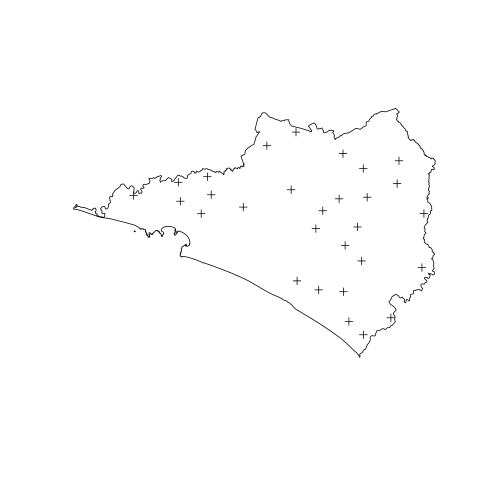

In [30]:
%%R
#Creamos un objeto de puntos espaciales, el signo negativo en data[,4] es porque tienen diferente referencia
shapeEsta=SpatialPoints(cbind(-data[,4],data[,5]))
#Fijamos el mismo sistema de coordenadas para los puntos
crs(shapeEsta) <- crs(shapeCol)
#Graficamos el shape de Colima
plot(shapeCol)
#Agregamos las marcas de las estaciones
plot(shapeEsta,add=TRUE)


**Otro tipo de datos usado en geocomputación son mapas de elevación digital**

- Cargaremos el DEM de la misma zona.
- Veremos como remarcar como un hillshade el mapa. 

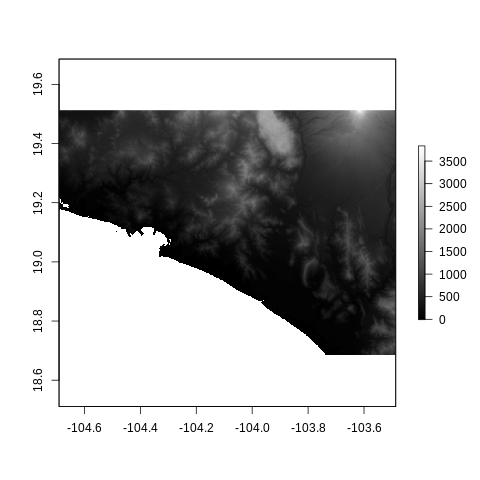

In [31]:
%%R
system("gdown --id 1Iz9ZPiR5_iTi2agQ4inUW65d_rGDtqMk")#https://drive.google.com/file/d/1Iz9ZPiR5_iTi2agQ4inUW65d_rGDtqMk/view?usp=sharing
srtm <- raster("colima.tif") #Imagen original con el mapa de elevación digital
plot(srtm, col=grey(0:100/100))


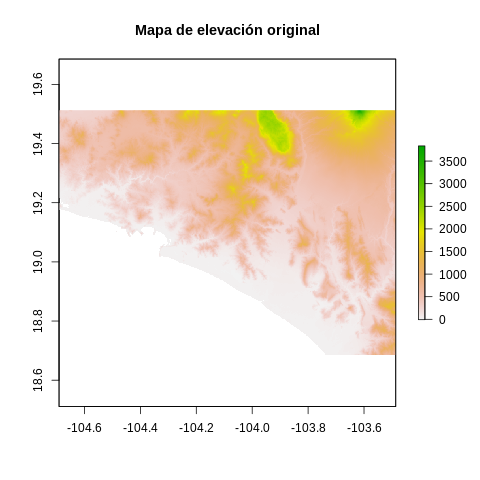

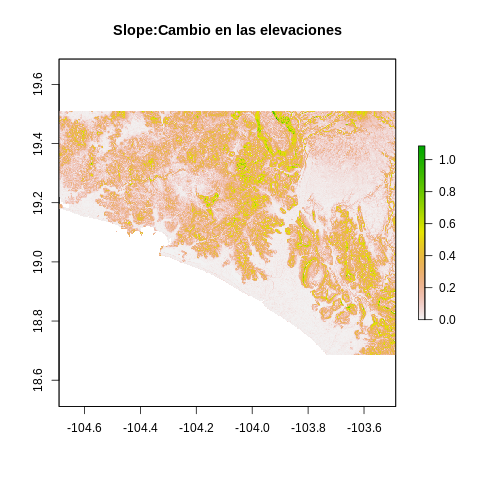

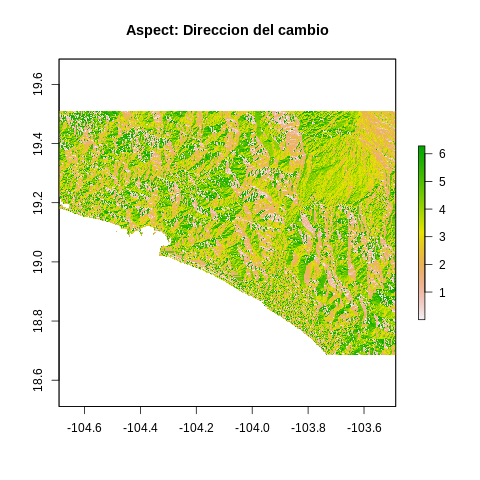

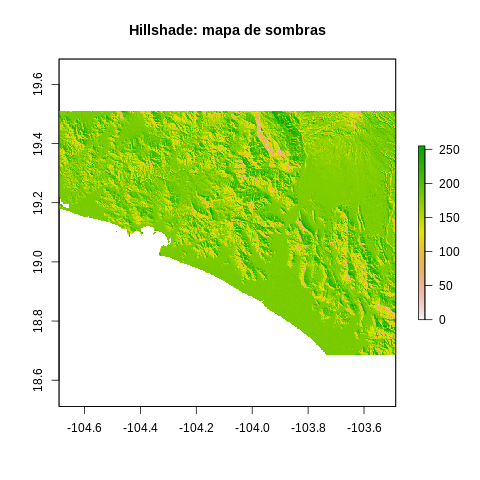

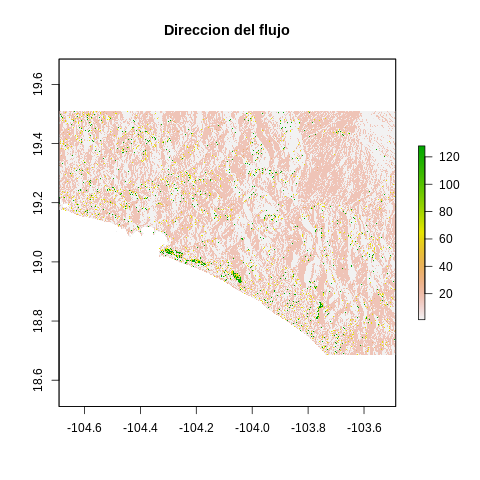

In [32]:
%%R

slope <- terrain(srtm, opt = "slope")
aspect <- terrain(srtm, opt = "aspect")
flowdir <- terrain(srtm, opt = "flowdir")
hill <- hillShade(slope, aspect, angle = 45, direction = 45, normalize = TRUE)
plot(srtm,main="Mapa de elevación original") #Son las elevaciones tal cual 
plot(slope, main="Slope:Cambio en las elevaciones") #Son los gradientes, indica cuanto cambia la elevación
plot(aspect, main="Aspect: Direccion del cambio") # Es la dirección del gradiente, o dice hacia donde está la pendiente
plot(hill, main="Hillshade: mapa de sombras") #Combina los anteriores para hacer un mapa de "sombras" que da la perspectiva de ver las elevaciones
plot(flowdir, main="Direccion del flujo") #Indica para donde fluiria el agua en el terreno

**Corte de un raster**

- Los DEM son públicos, aquí muestro como hacer el corte de Colima

- Sitio de descarga del DEM
https://dwtkns.com/srtm/

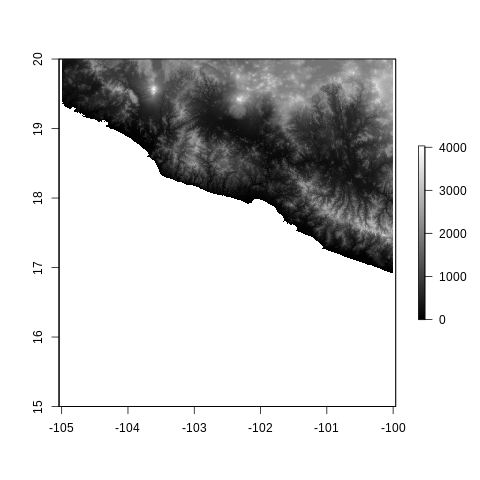

In [33]:
%%R
#Ejecutar
system("gdown --id 1-PGDUyu11YHRmDx8tZ5hfyieyRsSD7z0")#https://drive.google.com/file/d/1-PGDUyu11YHRmDx8tZ5hfyieyRsSD7z0/view?usp=sharing
#Lectura del mapa de elevacion descargado
srtm <- raster("srtm_16_09.tif") #Imagen original con el mapa de elevación digital
#graficamos
plot(srtm, col=grey(0:100/100))

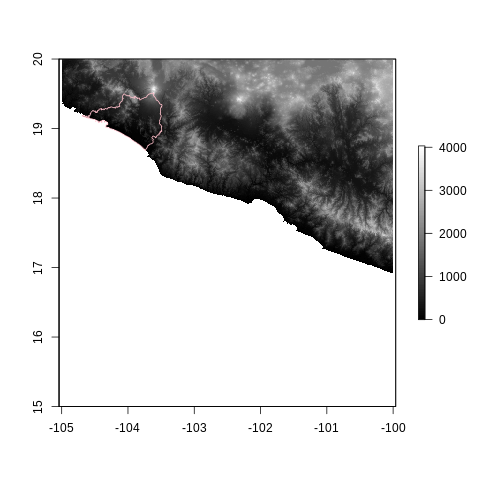

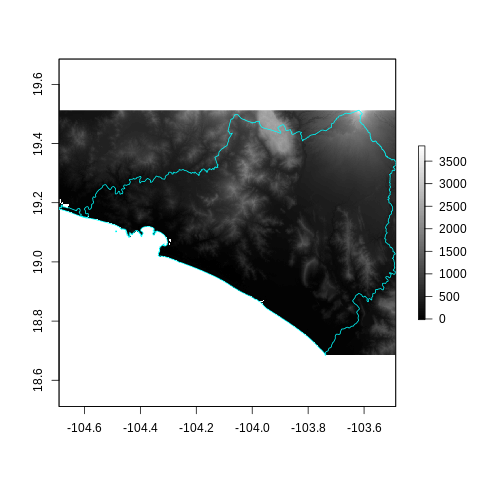

In [34]:
%%R

#Graficamos DEM y shape
plot(srtm, col=grey(0:100/100))
plot(shapeCol,border="pink",add=TRUE)
# #Cortamos sola la parte que queremos
rasterColima=crop(srtm,shapeCol)
# #Graficamos el corte
plot(rasterColima, col=grey(0:100/100))
plot(shapeCol,border="cyan",add=TRUE)
# #Almacenamos nuestro corte
writeRaster(rasterColima, filename="colima.tif", format="GTiff",overwrite=TRUE)


**Modelar la temperatura dependiente de las coordenadas**

- Utilizamos lo que ya vimos, generar un modelo lineal de la Temperatura en Colima, que depende de la Latitud y Longitud del punto.
- Los datos que *entrenan* al modelo son las estaciones, de la cuales tenemos *predictores=coordenadas(long,lat)*, *estimación=Temperatura*.
- Ya que entrenamos el modelo lo usamos para *predecir* o *estimar* los valores de todo el raster.
- Generamos un nuevo raster y lo visualizamos

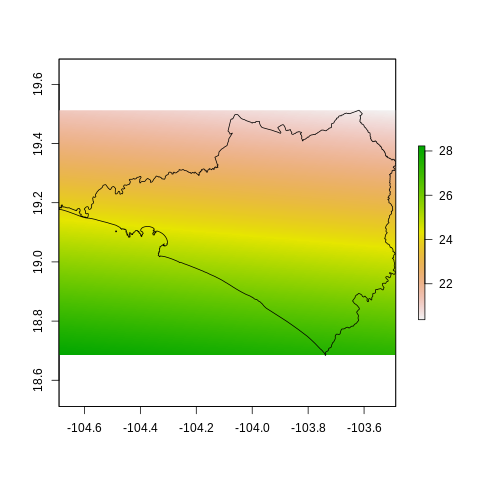

In [35]:
%%R

#Datos de entrenamiento longitud, latitud y temperatura de marzo de 2011
trainData=data[,c("LONGITUD..W.","LATITUD..N.","Tmar2011")]
#Recordemos que esta coordenada esta al reves
trainData[,1]=-trainData[,1]
#Le asigno nombres a los campos en los datos de entrenamiento
names(trainData)=c("long","lat","T")
#Creo el modelo lineal especificando que T es explicada por long y lat
mdl=lm(T~long+lat,trainData)
#Obtengo las coordenadas en latitud y longitud de todo el DEM de colima
testData=data.frame(coordinates(rasterColima))
#Le pongo nombre a los campos de los datos que voy predecir/estimar
names(testData)=c("long","lat")
#Realizo la predicción con mi modelo lineal
testData$T=predict(mdl,testData)
#Creo una copia del raster, con esto aseguro que pase las mismas coordenadas y proyección
rasterT=rasterColima
#Asigno los valores estimados al raster nuevo
values(rasterT)=testData$T
#Grafico el nuevo raster de temperaturas
plot(rasterT)
#Veo el contorno del estado
plot(shapeCol,border="black",add=TRUE)

**Podemos mejorar la visualización**

- Pondremos el hillshade de elevación digital en gris.
- Sobre ese le ponemos el raster de temperaturas en colores de azul a rojo.
- Ponemos los puntos de las estaciones en la misma escala de colores.
- Ponemos el contorno
- Hacemos una mascara del contorno

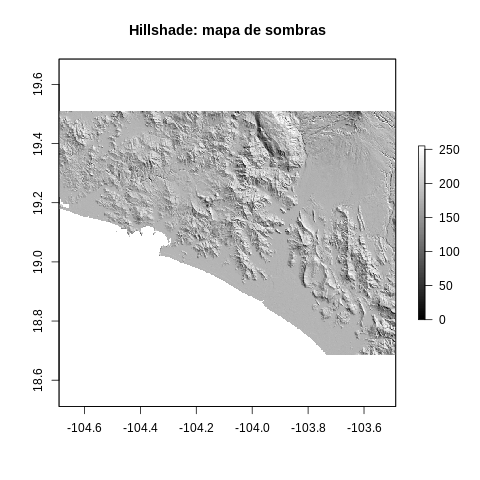

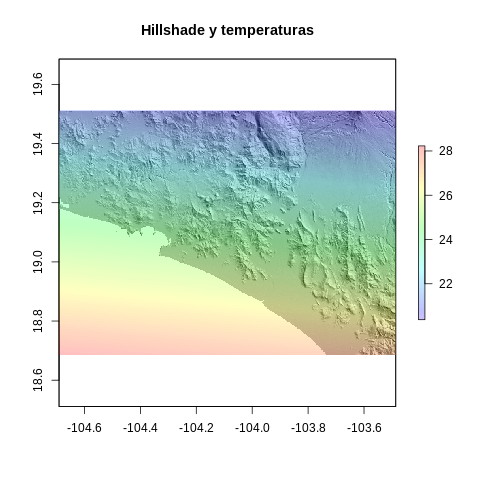

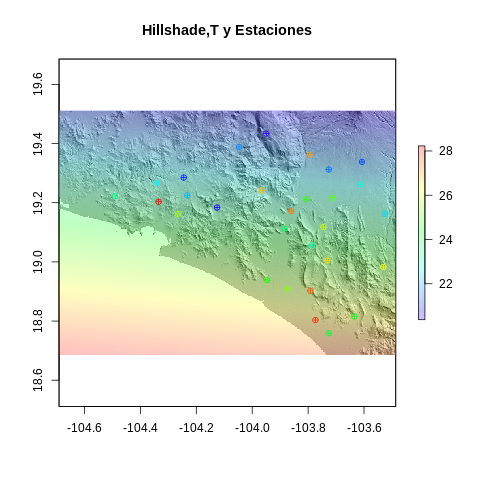

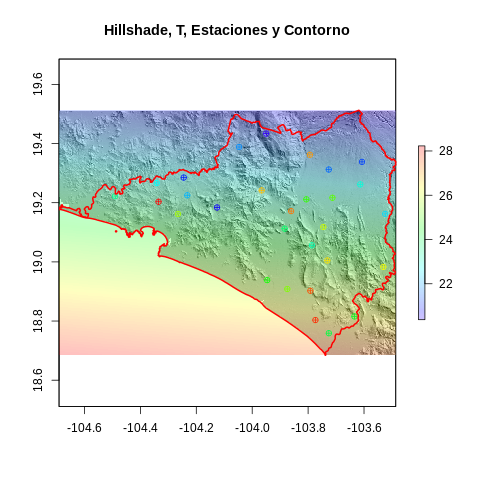

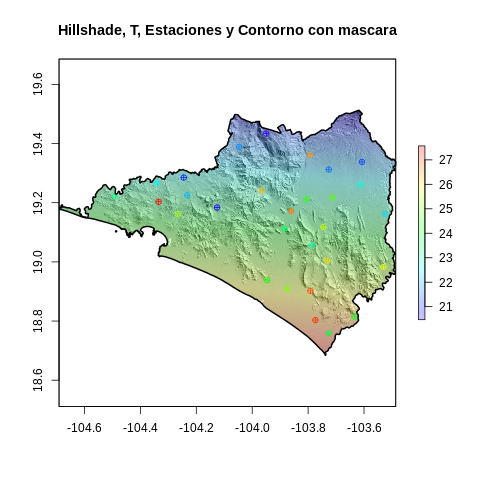

In [36]:
%%R
#Hillshade solo
plot(hill,col=grey(0:100/100),main="Hillshade: mapa de sombras") 
#Hillshade con estimaciones de temperatura
plot(hill,col=grey(0:100/100),main="Hillshade y temperaturas",legend=FALSE) #Quite la leyenda de aqui 
plot(rasterT,col=rainbow(100,start=0,end=0.7,rev=TRUE),alpha=0.25,add=TRUE) #Para que se vea bien la leyenda aqui
#Hillshade, estimaciones, y estaciones
plot(hill,col=grey(0:100/100),main="Hillshade,T y Estaciones",legend=FALSE)  
plot(rasterT,col=rainbow(100,start=0,end=0.7,rev=TRUE),alpha=0.25,add=TRUE)
#Calculo de colores
col=rainbow(nrow(data),start=0,end=0.7,rev=TRUE)
meses=names(data)[7:ncol(data)]
col2=col
Temperaturas=data[,"Tmar2011"]
iTemp=sort(Temperaturas,index.return=TRUE)$ix 
col2[iTemp]=col
plot(shapeEsta,add=TRUE,col=col2,pch=10,cex=1)

#Hillshade, estimaciones, estaciones y contorno
plot(hill,col=grey(0:100/100),main="Hillshade, T, Estaciones y Contorno",legend=FALSE)  
plot(rasterT,col=rainbow(100,start=0,end=0.7,rev=TRUE),alpha=0.25,add=TRUE)
plot(shapeEsta,add=TRUE,col=col2,pch=10,cex=1)
plot(shapeCol,border="red",lwd=2,add=TRUE)

#Hillshade, estimaciones, estaciones, contorno y mascara
maskedH= mask(x = hill, mask = shapeCol)
plot(maskedH,col=grey(0:100/100),main="Hillshade, T, Estaciones y Contorno con mascara",legend=FALSE)  
maskedT= mask(x = rasterT, mask = shapeCol)
plot(maskedT,col=rainbow(100,start=0,end=0.7,rev=TRUE),alpha=0.25,add=TRUE)
plot(shapeEsta,add=TRUE,col=col2,pch=10,cex=1)
plot(shapeCol,border="black",lwd=2,add=TRUE)

In [37]:
%%R

imgs=NULL
#Obtengo los nombres de los meses de la base de datos
meses=names(data)[7:ncol(data)]
for (mes in meses[1:3])
{
png(filename=paste(mes,".png",sep=""),width=1400,height=1400,res=200)
#Hillshade, estimaciones, estaciones, contorno y mascara
plot(maskedH,col=grey(0:100/100),main=paste("Temperatura",mes),legend=FALSE) 
#Datos de entrenamiento longitud, latitud y temperatura de marzo de 2011
trainData=data[,c("LONGITUD..W.","LATITUD..N.",mes)]
#Recordemos que esta coordenada esta al reves
trainData[,1]=-trainData[,1]
#Le asigno nombres a los campos en los datos de entrenamiento
names(trainData)=c("long","lat","T")
#Creo el modelo lineal especificando que T es explicada por long y lat
mdl=lm(T~long+lat,trainData)
#Obtengo las coordenadas en latitud y longitud de todo el DEM de colima
testData=data.frame(coordinates(rasterColima))
#Le pongo nombre a los campos de los datos que voy predecir/estimar
names(testData)=c("long","lat")
#Realizo la predicción con mi modelo lineal
testData$T=predict(mdl,testData)
#Creo una copia del raster, con esto aseguro que pase las mismas coordenadas y proyección
rasterT=rasterColima
#Asigno los valores estimados al raster nuevo
values(rasterT)=testData$T
col=rainbow(nrow(data),start=0,end=0.7,rev=TRUE)
col2=col
Temperaturas=data[,mes]
iTemp=sort(Temperaturas,index.return=TRUE)$ix 
col2[iTemp]=col
plot(shapeEsta,add=TRUE,col=col2,pch=10,cex=1) 
maskedT= mask(x = rasterT, mask = shapeCol)
plot(maskedT,col=rainbow(100,start=0,end=0.7,rev=TRUE),alpha=0.25,add=TRUE)
plot(shapeEsta,add=TRUE,col=col2,pch=10,cex=1)
plot(shapeCol,border="red",lwd=2,add=TRUE)
dev.off()
}

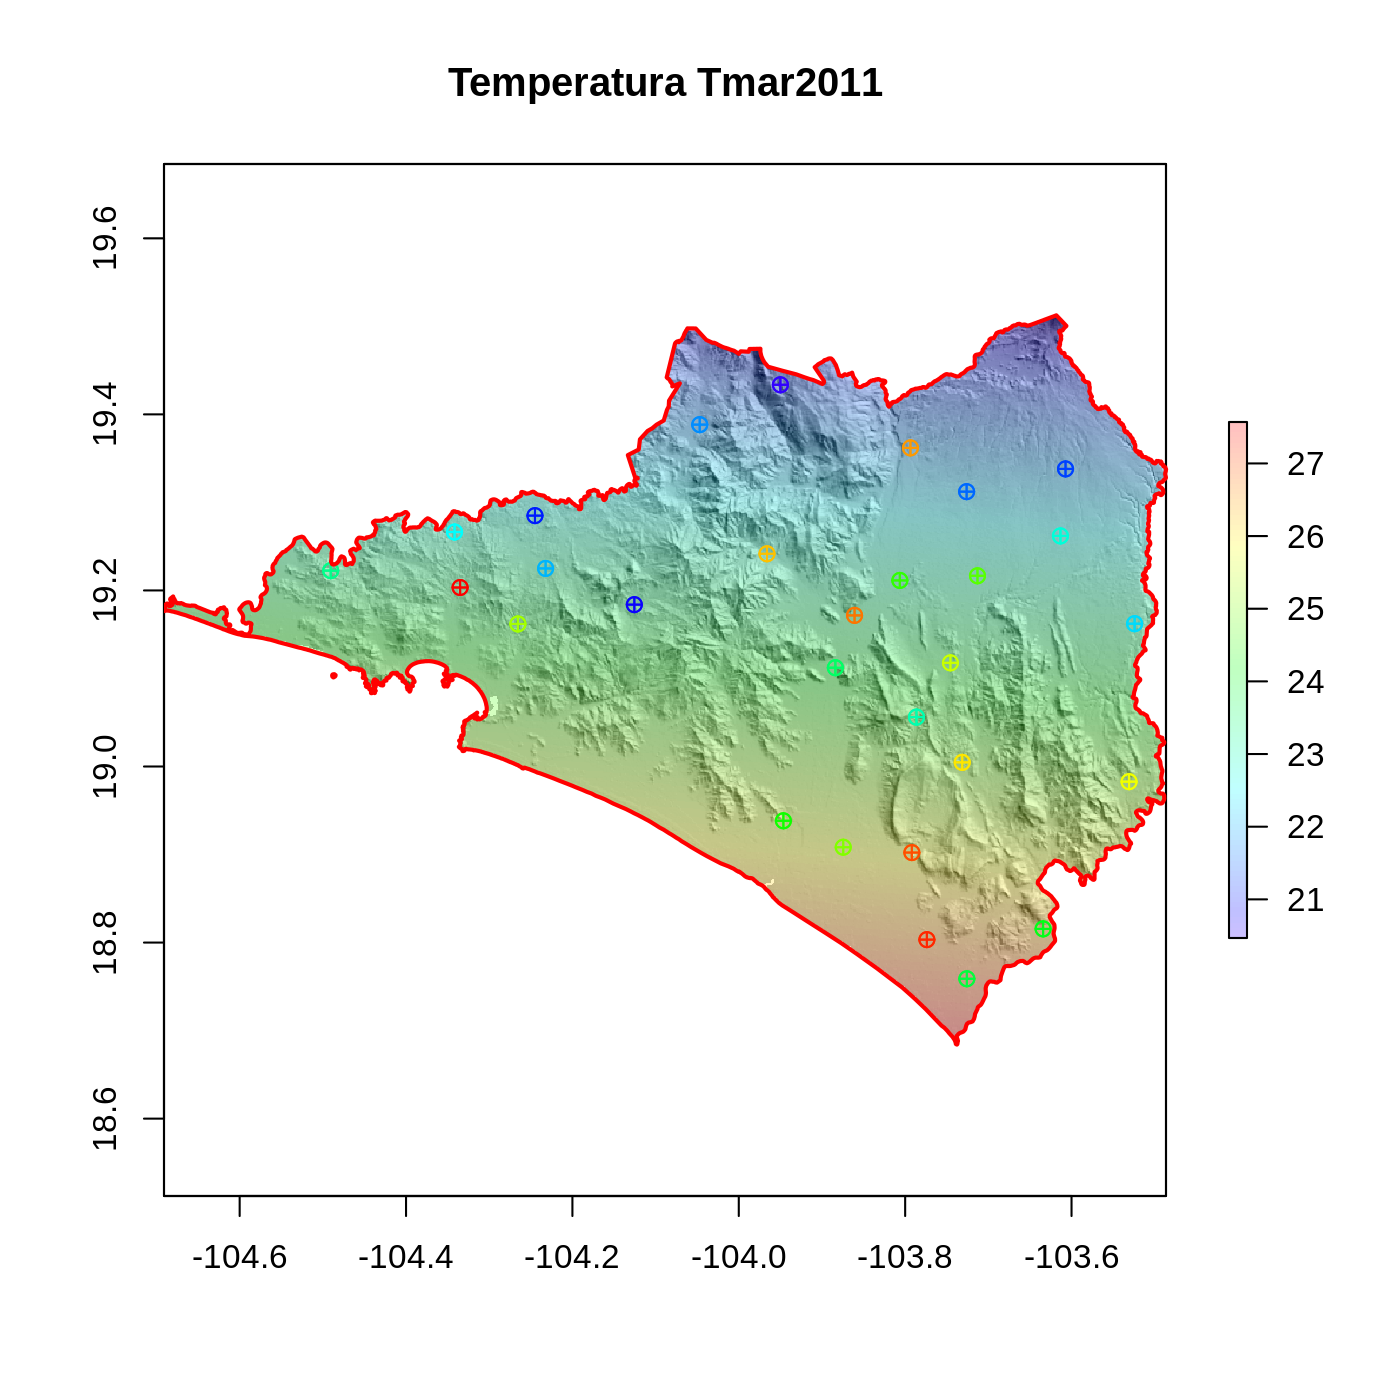

In [38]:
from IPython.display import Image, display

display(Image('Tmar2011.png'))